In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IsotonicPEP import IsotonicPEP

In [18]:
def estimate_q(df, pep_col):
    df = df.copy()
    df.index += 1
    df[f"q_est_{pep_col}"] = df[pep_col].cumsum() / df.index
    return df

def cal_max_rel_diff(q_value, q_est):
    relative_difference = np.abs(q_est - q_value) / np.where(q_value != 0, q_value, np.nan)
    return np.nanmax(relative_difference) * 100

pep_processor = IsotonicPEP()
c1, c2= "block_merge", "clip"
s1, s2 = "real", "logit"
p1, p2 = "basic", "interp"
m1 = ("real_basic_bm", c1, s1, p1)
m2 = ("real_interp_bm", c1, s1, p2)
m3 = ("logit_basic_bm", c1, s2, p1)
m4 = ("logit_interp_bm", c1, s2, p2)
m5 = ("real_basic_clip", c2, s1, p1)
m6 = ("real_interp_clip", c2, s1, p2)
m7 = ("logit_basic_clip", c2, s2, p1)
m8 = ("logit_interp_clip", c2, s2, p2)

Results saved to: data/iso0.q_pep.txt
Max relative difference:
real_basic_bm: 59%
real_interp_bm: 59%
logit_basic_bm: 92%
logit_interp_bm: 92%
real_basic_clip: 80%
real_interp_clip: 83%
logit_basic_clip: 92%
logit_interp_clip: 92%


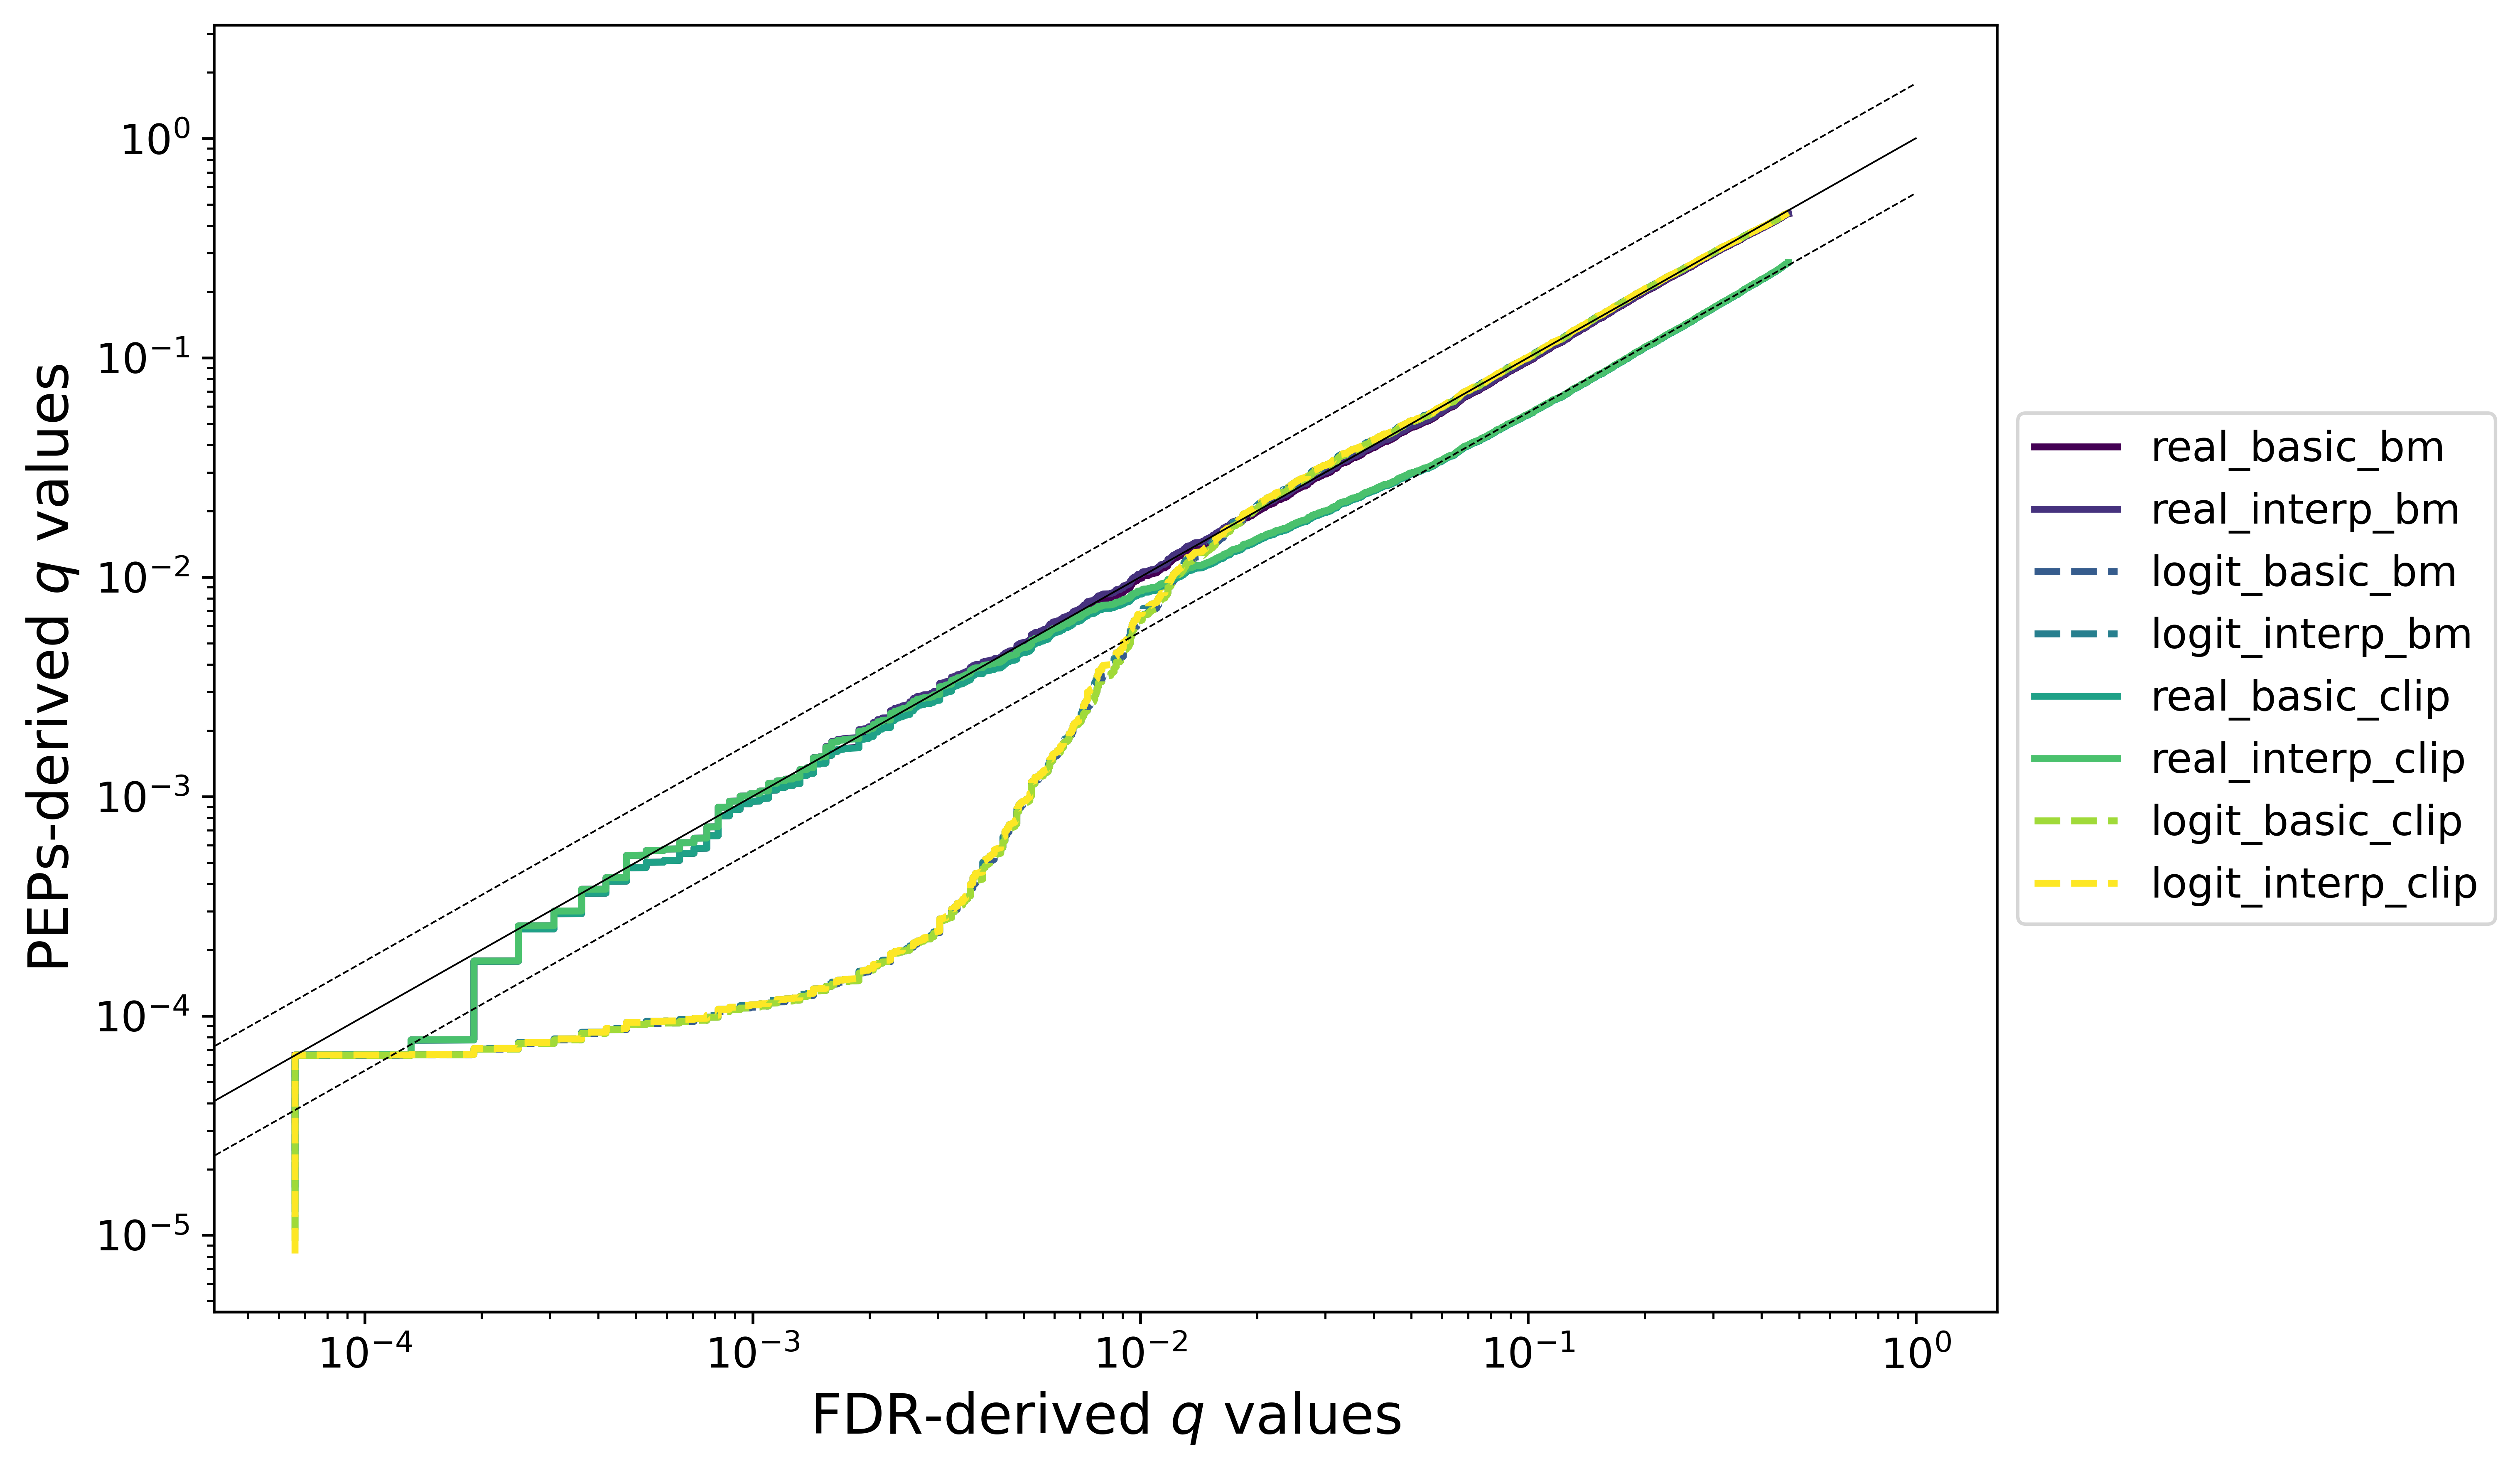

In [19]:
methods = [m1, m2, m3, m4, m5, m6, m7, m8]
input_file = "data/iso0.peptide.target.txt"
df = pd.read_csv(input_file, sep="\t")
q_values = df["q-value"].values
for col_name, raw_method, space, pava_method in methods:
    df[col_name] = pep_processor.pep_regression(q_values, raw_method, space, pava_method)
    df = estimate_q(df, col_name)
columns_to_drop = ["PSMId", "filename", "score", "peptide", "proteinIds"]
df = df.drop(columns=columns_to_drop)
output_file = "data/iso0.q_pep.txt"
df.to_csv(output_file, sep="\t", index=False)

print("Results saved to:", output_file)
print(f"Max relative difference:")
for col_name, _, _, _ in methods:
    max_diff = cal_max_rel_diff(df["q-value"].values, df[f"q_est_{col_name}"].values)
    print(f"{col_name}: {max_diff:.0f}%")

plt.figure(figsize=(12, 6), dpi=600)
linestyle_map = {"real": "-", "logit": "--"}
colors = plt.cm.viridis(np.linspace(0, 1, len(methods)))
for i, (col_name, _, space, _) in enumerate(methods):
    linestyle = linestyle_map[space]
    color = colors[i]
    plt.plot(df["q-value"], df[f"q_est_{col_name}"], label=col_name, linestyle=linestyle, color=color, linewidth=2)
a = np.linspace(0, 1, 100)
b = a / 10 ** 0.25
c = a * 10 ** 0.25
plt.plot(a, b, c="k", linewidth=0.5, linestyle="--")
plt.plot(a, c, c="k", linewidth=0.5, linestyle="--")
plt.plot(a, a, c="k", linewidth=0.5)
plt.xlabel("FDR-derived $q$ values", fontsize=16)
plt.ylabel("PEPs-derived $q$ values", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.xscale("log")
plt.yscale("log")
plt.show()